In [ ]:
using Plots
using LinearAlgebra
using ForwardDiff
using ControlSystems
using OrdinaryDiffEq
using KernelFunctions
using Distributions
using Random: seed!
seed!(42);

In [3]:
function genSignal_output(sys,n,m,time,l,x0)
    outputx=[]
    outputy=[]
    t=range(0,time,length=l)
    for ome in range(-5,5,n)
        for a in range(0,0.01,m)
            signal=[sin(exp(ome)*x)/(1+10*exp(-a*x)) for x in range(0,time,length=l)]
            u(x,t) = [sin(exp(ome)*t)/(1+10*exp(-a*t))]
            y, _, x, uout = lsim(sys,u,t,x0=x0);
            push!(outputy,y[1,:])
            push!(outputx,signal)
        end;
    end;
    return t,outputx,outputy
end;

function genRandSignal_output(sys,n,m,time,l,x0)
    outputx=[]
    outputy=[]
    t=range(0,time,length=l)
    for ome in range(-5,5,n)
        for a in range(0,0.01,m)
            noise=rand(Uniform(0, 1), 2)
            signal=[sin(exp(ome)*x*noise[1])/(1+10*exp(-a*x*noise[2])) for x in range(0,time,length=l)]
            u(x,t) = [sin(exp(ome)*t*noise[1])/(1+10*exp(-a*t*noise[1]))] 
            y, _, x, uout = lsim(sys,u,t,x0=x0);
            push!(outputy,y[1,:])
            push!(outputx,signal)
        end;
    end;
    return t,outputx,outputy
end;

function genRandSignal_output_sine(sys,n,m,time,l,x0)
    outputx=[]
    outputy=[]
    t=range(0,time,length=l)
    for ome in range(-5,5,n)
        for a in range(0,0.01,m)
            noise=rand(Uniform(0.8, 1), 2)
            signal=[sin(exp(ome)*x)+cos(0.5*x) for x in range(0,time,length=l)]
            u(x,t) = [sin(exp(ome)*t)+cos(0.5*t)] 
            y, _, x, uout = lsim(sys,u,t,x0=x0);
            push!(outputy,y[1,:])
            push!(outputx,signal)
        end;
    end;
    return t,outputx,outputy
end;

In [4]:
P = tf(zpk([-1], [-3, -10], 1))
x0=zeros(2);

In [5]:
function KRR_fit(k, X, y,lambda=1e-4)
    K = kernelmatrix(k, RowVecs(X))*(Time/samples)
    weight=((K + lambda * I) \ y)
    return weight
end;

function KRR_prediction(k,weight,X,Xstar)
    kstar = kernelmatrix(k, RowVecs(Xstar),RowVecs(X))*(Time/samples)
    return kstar *weight
end;

function kernel_ridge_regression(k, X, y, Xstar, lambda=1e-4)
    weight=KRR_fit(k, X, y, lambda)
    return KRR_prediction(k,weight,X,Xstar)
end;

function prediction_error(y,ypre)
    error=sum((y.-ypre).^2)^(1/2)
    return(error)/length(y)
end;

function kernelized_fit_and_plot(kernel,x_train, y_train, x_test, lambda=1e-4)
    y_pred = kernel_ridge_regression(kernel, x_train, y_train, x_test, lambda)
    if kernel isa PolynomialKernel
        title = string("order ", kernel.degree)
    else
        title = string(nameof(typeof(kernel)))
    end
    scatter(x_train, y_train; label=nothing)
    return plot!(x_test, y_pred; label=nothing, title=title)
end;


function genSignal_output_step(sys,m,n,time,l,x0)
    outputx=[]
    outputy=[]
    t=range(0,time,length=l)
    for a in range(0,1,m)
            signal=[exp(50*x)/(exp(50*x)+1)*a for x in range(0,time,length=l)]
            u(x,t) = [exp(50*t)/(exp(50*t)+1)*a] 
            y, _, x, uout = lsim(sys,u,t,x0=x0);
            push!(outputy,y[1,:])
            push!(outputx,signal)
    end;
    return t,outputx,outputy
end;

In [72]:
function demo_input(X_demo,Y_demo,fading_weight)
    demo_=Vector{Float64}[]
    for i=1:length(X_demo)/10
        push!(demo_,[zeros(length(X_demo)-trunc(Int, i*10));X_demo[1:trunc(Int, i*10)]].*fading_weight)
    end;
    return mapreduce(permutedims, vcat, demo_)
end;


function plot_demo(lambda,kernel,weights,tsample,X_train,X_demo,Y_demo,fading_weight,saveing=false,name="figure")
    demo=demo_input(X_demo,Y_demo,fading_weight)
    y_pre_demo=KRR_prediction(kernel,weights,X_train,demo)
    fig1=plot([tsample[trunc(Int, i*10)] for i=1:length(X_demo)/10],[y_pre_demo,[Y_demo[trunc(Int, i*10)] for i=1:length(X_demo)/10]],lab=["Approximated system" "Real system"],xlabel="time/s", ylabel="magnitude",fmt = :png)
    plot!(title="lambda="*string(lambda),dpi=300)
    if (saveing) savefig(fig1,Folder*"lambda="*string(lambda)*"_"*name*".png") end;
    plot(fig1)
end;



function test_result(kernel,weights,X_train,X_val,Y_val,X_test,y_test,X_test2,Y_test2)
    y_pre=KRR_prediction(kernel, weights,X_train,X_val)
    println(prediction_error(Y_val,y_pre))
    y_pre=KRR_prediction(kernel, weights,X_train,X_test)
    println(prediction_error(Y_test,y_pre))
    y_pre=KRR_prediction(kernel, weights,X_train,X_test2)
    println(prediction_error(Y_test2,y_pre))
end;

function produce_pics(lambdas,kernel,tsample,styles,x,y,x_val,y_val,x_test,y_test,x_test2,y_test2,saveing=false,name="full")
    X_demo=x_test2[5]
    Y_demo=y_test2[5]
    t=[tsample[trunc(Int, i*10)] for i=1:length(X_demo)/10]
    plot(t,[Y_demo[trunc(Int, i*10)] for i=1:length(X_demo)/10],linewidth=2,linecolor=RGBA{Float64}(0, 0, 1, 0.3),lab="Real system",xlabel="time/s", ylabel="magnitude",fmt = :png)
    for (index,lambda) in enumerate(lambdas)
        fading_weight=[exp(lambda*(tsample[i]-Time)) for i=1:length(tsample)]
        X_train=[x[i].*fading_weight for i=1:length(x)]
        Y_train=[last(y[i]) for i=1:length(y)];
        X_train=reduce(vcat,map(permutedims,X_train));
        weights=KRR_fit(LinearKernel(), X_train, Y_train,1e-6)
        demo=demo_input(X_demo,Y_demo,fading_weight)
        y_pre_demo=KRR_prediction(kernel,weights,X_train,demo)
        plot!(t,y_pre_demo,lab="Approximation,"*"lambda="*string(lambda),xlabel="time/s", ylabel="magnitude",fmt = :png,linestyle = styles[index])
    end;
    plot!(dpi=300)
    if (saveing) savefig(Folder*name*".png") end
    
end;

In [7]:
Folder="C:/"
Time=2
samples=5000
tsample,x,y=genSignal_output(P,100,2,Time,samples,x0)
tsample,x_val,y_val=genRandSignal_output(P,5,5,Time,samples,x0)
tsample,x_test,y_test=genRandSignal_output_sine(P,5,5,Time,samples,x0);
tsample,x_test2,y_test2=genSignal_output_step(P,5,5,Time,samples,x0);

In [ ]:
produce_pics([1 2 3 7 9 12],LinearKernel(),tsample,[:auto, :dash, :dashdot, :dashdotdot, :dot, :solid],x,y,x_val,y_val,x_test,y_test,x_test2,y_test2,true)

In [73]:
lambda=1;

In [74]:
fading_weight=[exp(lambda*(tsample[i]-Time)) for i=1:length(tsample)]
X_train=[x[i].*fading_weight for i=1:length(x)]
Y_train=[last(y[i]) for i=1:length(y)];
X_test=[x_test[i].*fading_weight for i=1:length(x_test)]
Y_test=[last(y_test[i]) for i=1:length(y_test)];
X_val=[x_val[i].*fading_weight for i=1:length(x_val)]
Y_val=[last(y_val[i]) for i=1:length(y_val)];
X_test2=[x_test[i].*fading_weight for i=1:length(x_test2)]
Y_test2=[last(y_test[i]) for i=1:length(y_test2)];
X_train=reduce(vcat,map(permutedims,X_train));
X_test=reduce(vcat,map(permutedims,X_test));
X_val=reduce(vcat,map(permutedims,X_val));
X_test2=reduce(vcat,map(permutedims,X_test2));

In [86]:
weights=KRR_fit(LinearKernel(), X_train, Y_train,1e-6)
test_result(LinearKernel(),weights,X_train,X_val,Y_val,X_test,y_test,X_test2,Y_test2)

2.7349512726887156e-6
1.7696908852302069e-6
4.676155614914065e-6


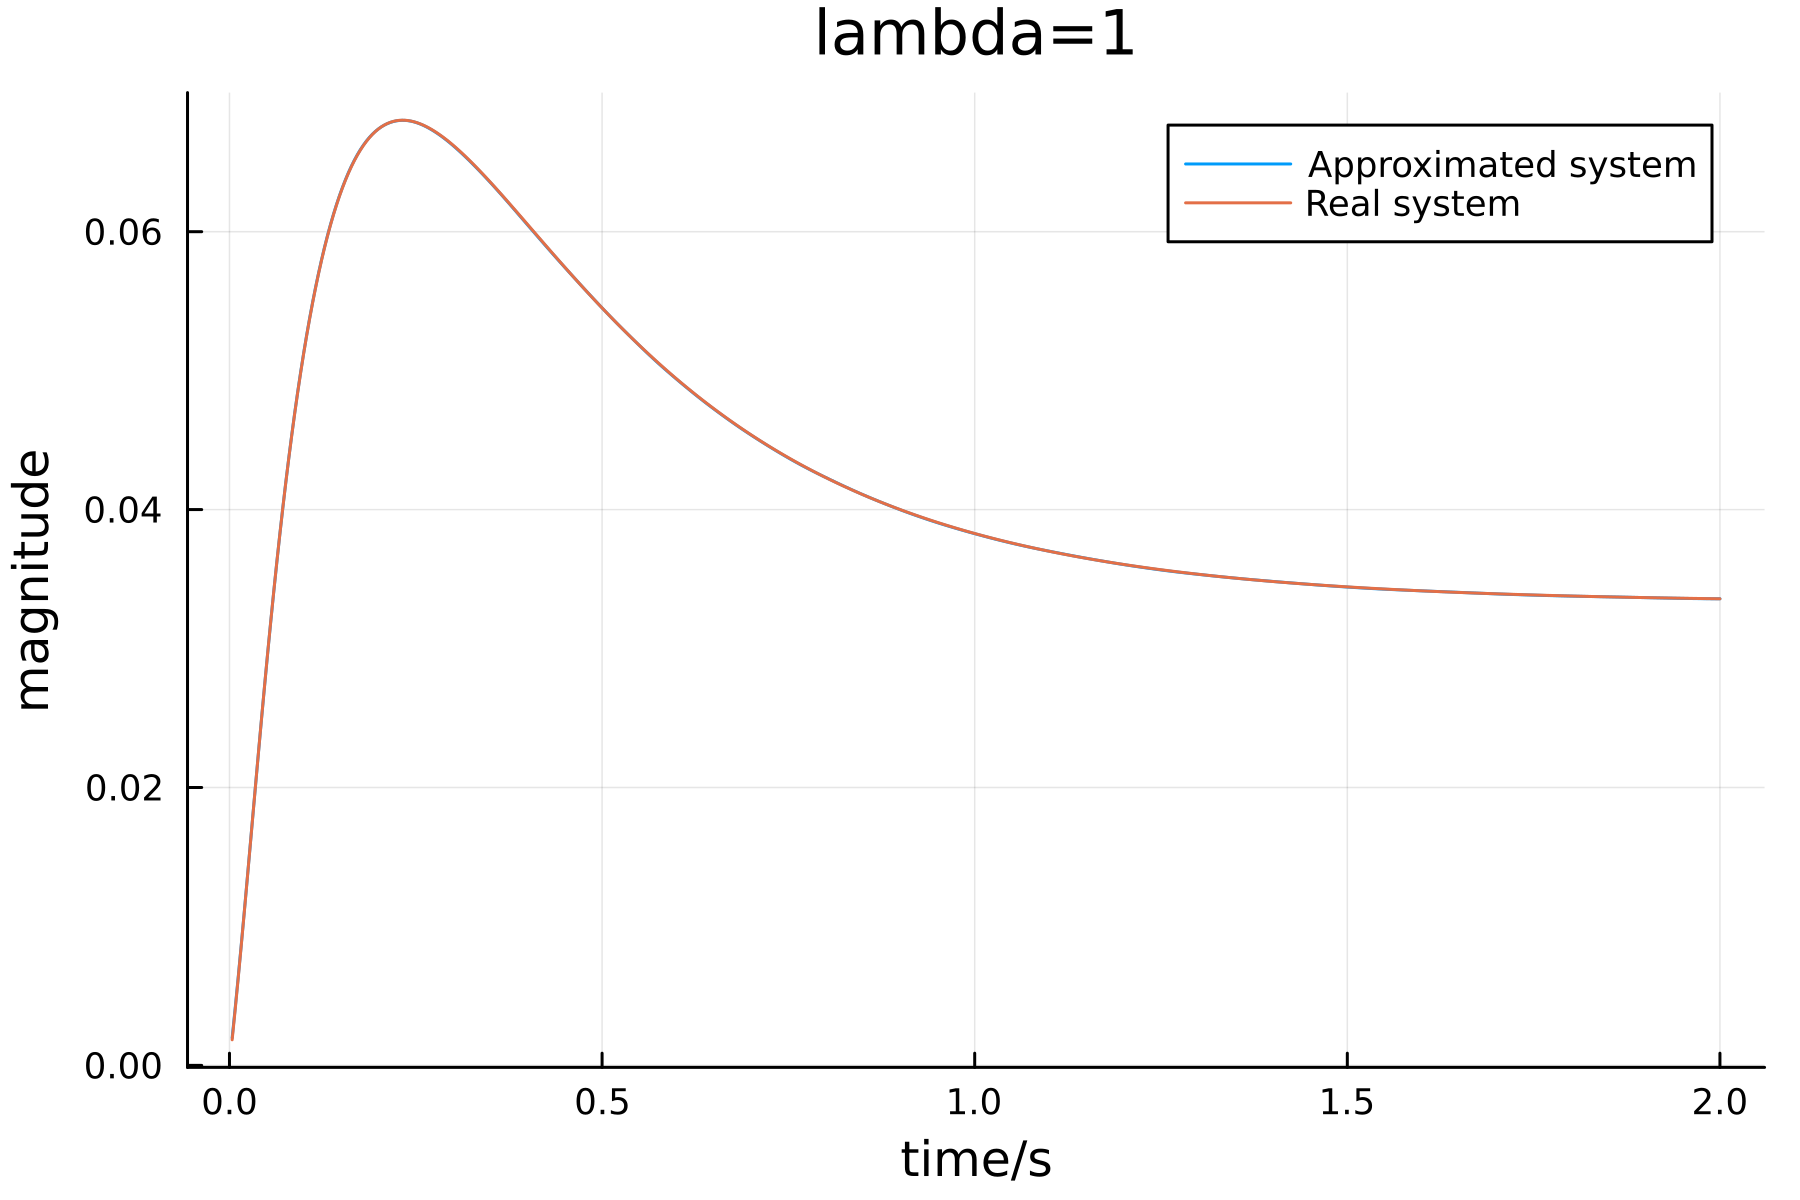

In [87]:
X_demo=x_test2[5]
Y_demo=y_test2[5]
plot_demo(LinearKernel(),weights,tsample,X_train,X_demo,Y_demo,fading_weight,true)